# Exercise 1
Rebuild , compile and train `model_1`, `model_2` and `model_5` using the `Keras Sequential API` instead of `Functional API`.

## Check the GPU

In [1]:
# Check for the GPU
!nvidia-smi

Thu Mar 30 16:26:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get the helper functions

In [2]:
# Download the helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback

--2023-03-30 16:26:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-30 16:26:49 (79.1 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



## Get a text dataset

In [3]:
# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data('nlp_getting_started.zip')

--2023-03-30 16:27:03--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.74.128, 173.194.192.128, 209.85.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.74.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.1’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2023-03-30 16:27:03 (112 MB/s) - ‘nlp_getting_started.zip.1’ saved [607343/607343]



In [4]:
import pandas as pd

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [5]:
# Shuffling the test dataset
train_data_shuffled = train_data.sample(frac=1, random_state=42)
train_data_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


### Split the data into training/validations sets

In [6]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_data_shuffled['text'],
                                                                            train_data_shuffled['target'],
                                                                            test_size=0.1,
                                                                            random_state=42)

In [7]:
# Check the lengths
len(train_sentences) == len(train_labels), len(val_sentences) == len(val_labels)

(True, True)

## Converting text data into numerical data

### Tokenization

In [8]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [9]:
# Setup the vectorization variables
max_vocab_length = 10000
max_length = 15

In [10]:
# Setup the TextVectorization 
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int', 
                                    output_sequence_length=max_length)

In [11]:
# Fit the text vectorizer to the training set
text_vectorizer.adapt(train_sentences)

In [12]:
# Create a sample set and vectorize it
sample_sentence = "We'd love the aliens to visit us!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[1924,  110,    2, 6238,    5, 1742,   69,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [13]:
# Checking the vocabulary
vocab = text_vectorizer.get_vocabulary()
print(f"Top 5 most used words: {vocab[:5]}")
print(f"Top 5 least used words: {vocab[-5:]}")

Top 5 most used words: ['', '[UNK]', 'the', 'a', 'in']
Top 5 least used words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Embedding

In [14]:
from tensorflow.keras import layers

# Create embedding layer
embedding = layers.Embedding(input_dim=max_vocab_length, # input shape
                             output_dim=128, # output shape
                             input_length=max_length) # input length

embedding

In [15]:
# Check if it works
print(f"Sample sentence: \n{sample_sentence}")
print(f"\nSample sentence vectorized: \n{text_vectorizer([sample_sentence])}")
print(f"\nSample sentence embedded: \n{embedding(text_vectorizer([sample_sentence]))}")

Sample sentence: 
We'd love the aliens to visit us!

Sample sentence vectorized: 
[[1924  110    2 6238    5 1742   69    0    0    0    0    0    0    0
     0]]

Sample sentence embedded: 
[[[ 0.04024145  0.02826763 -0.01733495 ... -0.00817807 -0.03772618
    0.00909243]
  [-0.01254985 -0.0183527   0.02229034 ... -0.02459335  0.00236881
   -0.02766861]
  [-0.02200384 -0.00678872  0.0171239  ... -0.01047204  0.04456098
   -0.0227617 ]
  ...
  [-0.01326926  0.01977272 -0.00883738 ...  0.02691862  0.00315139
    0.0124912 ]
  [-0.01326926  0.01977272 -0.00883738 ...  0.02691862  0.00315139
    0.0124912 ]
  [-0.01326926  0.01977272 -0.00883738 ...  0.02691862  0.00315139
    0.0124912 ]]]


## Helper function to evaluate the models

In [16]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  # Calculate model accuracy
  accuracy = accuracy_score(y_true, y_pred)

  # Calculate precision, recall and f1-score (in 'weighted' mode)
  precision, recall, f1, _ = precision_recall_fscore_support(y_true,
                                                             y_pred,
                                                             average='weighted')
  
  results = {'accuracy': accuracy,
             'precision': precision,
             'recall': recall,
             'f1-score': f1}

  return results

In [17]:
# Create TensorBoard callback
from helper_functions import create_tensorboard_callback

SAVE_DIR = 'exercise_model_logs'

## Model 1 reproduction - simple dense model





In [18]:
# Create the model with Sequential API
model_1 = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    text_vectorizer,
    embedding,
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation='sigmoid')
], name='model_1_dense')

model_1.summary()

# Compile the model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Fit the model 
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                    'model_1_dense_Sequential')],
                              verbose=2)

Saving TensorBoard log files to: exercise_model_logs/model_1_dense_Sequential/20230330-153318
Epoch 1/5
215/215 - 24s - loss: 0.6146 - accuracy: 0.6859 - val_loss: 0.5370 - val_accuracy: 0.7546 - 24s/epoch - 112ms/step
Epoch 2/5
215/215 - 3s - loss: 0.4439 - accuracy: 0.8168 - val_loss: 0.4725 - val_accuracy: 0.7861 - 3s/epoch - 12ms/step
Epoch 3/5
215/215 - 2s - loss: 0.3481 - accuracy: 0.8596 - val_loss: 0.4568 - val_accuracy: 0.7900 - 2s/epoch - 8ms/step
Epoch 4/5
215/215 - 1s - loss: 0.2860 - accuracy: 0.8907 - val_loss: 0.4636 - val_accuracy: 0.7822 - 1s/epoch - 6ms/step
Epoch 5/5
215/215 - 1s - loss: 0.2391 - accuracy: 0.9101 - val_loss: 0.4812 - val_accuracy: 0.7769 - 1s/epoch - 7ms/step


In [26]:
# Function to evaluate and predict
def evaluate_and_pred(model, data_to_predict, labels_to_predict):
  """
  Evaluates on data_to_predict and returns predictions as 1 or 0.
  """

  # Evaluate the model
  eval = model.evaluate(data_to_predict, labels_to_predict)
  print(f"Evaluation metrics: {eval}\n")

  # Get the predictions 
  pred_probs = model.predict(data_to_predict)
  preds = tf.squeeze(tf.round(pred_probs))

  print(f"Preds overview: {preds[:10]}")

  return preds

In [21]:
# Evaluation and preds
model_1_preds = evaluate_and_pred(model_1, val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4812 - accuracy: 0.7769
Evaluation metrics: [0.4812396168708801, 0.7769029140472412]

24/24 [==============================] - 0s 2ms/step
Preds overview: [0. 1. 1. 0. 0. 1. 1. 1. 1. 0.]


In [22]:
# Calculate the results
model_1_results = calculate_results(val_labels, model_1_preds)
model_1_results


{'accuracy': 0.7769028871391076,
 'precision': 0.7775711689884918,
 'recall': 0.7769028871391076,
 'f1-score': 0.7754662769426549}

## Model 2 - LSTM

In [23]:
from tensorflow.keras import layers

# Create the model
model_2 = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    text_vectorizer,
    embedding,
    layers.LSTM(units=64),
    layers.Dense(1, activation='sigmoid')
], name='model_2_lstm')

# Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

# Check the summary
model_2.summary()

Model: "model_2_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_2_lstm')],
                              verbose=2)

Saving TensorBoard log files to: exercise_model_logs/model_2_lstm/20230330-153350
Epoch 1/5
215/215 - 12s - loss: 0.2272 - accuracy: 0.9177 - val_loss: 0.5635 - val_accuracy: 0.7822 - 12s/epoch - 58ms/step
Epoch 2/5
215/215 - 2s - loss: 0.1551 - accuracy: 0.9415 - val_loss: 0.6192 - val_accuracy: 0.7822 - 2s/epoch - 10ms/step
Epoch 3/5
215/215 - 2s - loss: 0.1281 - accuracy: 0.9514 - val_loss: 0.7678 - val_accuracy: 0.7861 - 2s/epoch - 11ms/step
Epoch 4/5
215/215 - 2s - loss: 0.1058 - accuracy: 0.9609 - val_loss: 0.7198 - val_accuracy: 0.7769 - 2s/epoch - 9ms/step
Epoch 5/5
215/215 - 2s - loss: 0.0839 - accuracy: 0.9672 - val_loss: 0.8596 - val_accuracy: 0.7743 - 2s/epoch - 9ms/step


In [25]:
# Evaluate and predict
model_2_preds = evaluate_and_pred(model_2, val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.8596 - accuracy: 0.7743
Evaluation metrics: [0.8596174716949463, 0.7742782235145569]

24/24 [==============================] - 0s 3ms/step
Preds overview: [0. 1. 1. 0. 0. 1. 1. 1. 1. 1.]


In [26]:
# Calculate results
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

{'accuracy': 0.7742782152230971,
 'precision': 0.7757380419380466,
 'recall': 0.7742782152230971,
 'f1-score': 0.7723566516531356}

## Model 5 - 1D Convolutional NN

In [27]:
# Create the model
model_5 = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    text_vectorizer,
    embedding,
    layers.Conv1D(filters=64, 
                  kernel_size=5,
                  strides=1,
                  activation='relu',
                  padding='same'),
    layers.GlobalMaxPool1D(),
    layers.Dense(1, activation='sigmoid')
], name='model_5_conv1d')

# Compile the model
model_5.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

# Check the summary
model_5.summary()

Model: "model_5_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 15, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,321,089
Trainable params: 1,321,089


In [28]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_5_conv1d')])

Saving TensorBoard log files to: exercise_model_logs/model_5_conv1d/20230330-153413
Epoch 1/5
215/215 [==============================] - 15s 40ms/step - loss: 0.1454 - accuracy: 0.9514 - val_loss: 0.7996 - val_accuracy: 0.7874
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0970 - accuracy: 0.9657 - val_loss: 0.8668 - val_accuracy: 0.7887
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0763 - accuracy: 0.9699 - val_loss: 0.9698 - val_accuracy: 0.7835
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0658 - accuracy: 0.9742 - val_loss: 1.0390 - val_accuracy: 0.7848
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0602 - accuracy: 0.9756 - val_loss: 1.0562 - val_accuracy: 0.7822


In [29]:
# Evaluate and predict
model_5_preds = evaluate_and_pred(model_5, val_sentences, val_labels)

24/24 [==============================] - 0s 5ms/step - loss: 1.0562 - accuracy: 0.7822
Evaluation metrics: [1.0561649799346924, 0.7821522355079651]

24/24 [==============================] - 0s 4ms/step
Preds overview: [0. 1. 1. 0. 0. 1. 1. 1. 1. 1.]


In [30]:
# Calculate results
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

{'accuracy': 0.7821522309711286,
 'precision': 0.7829133858267716,
 'recall': 0.7821522309711286,
 'f1-score': 0.7807494233675335}

# Exercise 2
Retrain the baseline model with 10% of the training data. How does it perform to the Universal Sentence Encoder model with 10% of the training data?

In [31]:
# Getting the right amount of data for the split
train_10_percent_split = int(0.1 * len(train_sentences))

# Recreate the 10% training data split
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

# Check the split
print(f"Length of base set: {len(train_sentences)}")
print(f"Length of 10 percent set: {len(train_sentences_10_percent)}")

Length of base set: 6851
Length of 10 percent set: 685


In [32]:
# Recreating the baseline model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create pipeline with tokenization
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to 10% dataset
model_0.fit(train_sentences_10_percent, train_labels_10_percent)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [33]:
# Evaluate and pred
model_0_score = model_0.score(val_sentences, val_labels)
print(f"Baseline model score: {model_0_score}")

model_0_preds = model_0.predict(val_sentences)
model_0_preds[:10]

Baseline model score: 0.7020997375328084


array([1, 0, 1, 0, 0, 1, 0, 0, 1, 0])

In [34]:
# Calculate results
model_0_results = calculate_results(val_labels, model_0_preds)
model_0_results

{'accuracy': 0.7020997375328084,
 'precision': 0.7599524002753854,
 'recall': 0.7020997375328084,
 'f1-score': 0.6736831571468213}

## Answer
How did the model perform compared to USE model from `08` notebook?
* The USE model trained on 10% of the data did get about 77,5%.
* The retrained baseline model from `sklearn` with `MultinomialNB` classifier, also trained on about 70,2% accuracy.

**This shows that the smaller the dataset, maybe using the pretrained model from TF Hub is a good idea to include in the experiment workflow.**


# Exercise 3
Try fine-tuning the TF Hub USE (`model_6`) by setting `training=True` when instentiating it as a Keras layer.

In [35]:
# Importing the USE 
import tensorflow_hub as hub
USE_URL = "https://tfhub.dev/google/universal-sentence-encoder/4"
embed = hub.load(USE_URL)

# Try out the USE
embed_sample = embed([sample_sentence])
print(embed_sample[0][:20])

tf.Tensor(
[ 0.00910182 -0.01275036 -0.02675992 -0.06155284  0.00590177 -0.06304007
 -0.04478857 -0.06164155 -0.0416155  -0.05248841  0.06968987  0.02778338
 -0.03118138  0.0318342  -0.01928731 -0.08036631  0.00304866 -0.05874979
 -0.02073362  0.04330571], shape=(20,), dtype=float32)


In [22]:
# Create a Keras Layer using the USE pretrained layer from TensorFlow Hub
sentence_encoder_layer = hub.KerasLayer(handle=USE_URL,
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE_fine_tuned')

In [23]:
# Create the model
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    #layers.Dense(32, activation='relu'),
    #layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid', name='output_layer')
], name='model_6_USE')

# Compile the model
model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Summary
model_6.summary()

# Layer status
for layer in model_6.layers:
  print(layer.trainable, layer.name)

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE_fine_tuned (KerasLayer)  (None, 512)              256797824 
                                                                 
 dense_1 (Dense)             (None, 32)                16416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 256,814,273
Trainable params: 16,449
Non-trainable params: 256,797,824
_________________________________________________________________
False USE_fine_tuned
True dense_1
True dropout_1
True output_layer


In [24]:
# Fit the model
tf.random.set_seed(42)

initial_epochs = 5

model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=initial_epochs,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_6_USE')]
                              )

Saving TensorBoard log files to: exercise_model_logs/model_6_USE/20230330-164213
Epoch 1/5
215/215 [==============================] - 7s 14ms/step - loss: 0.5368 - accuracy: 0.7825 - val_loss: 0.4661 - val_accuracy: 0.7940
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4356 - accuracy: 0.8085 - val_loss: 0.4476 - val_accuracy: 0.8071
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4184 - accuracy: 0.8155 - val_loss: 0.4404 - val_accuracy: 0.8097
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.4097 - accuracy: 0.8216 - val_loss: 0.4399 - val_accuracy: 0.8071
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.4035 - accuracy: 0.8243 - val_loss: 0.4356 - val_accuracy: 0.8136


In [27]:
# Check the results
model_6_preds = evaluate_and_pred(model_6, val_sentences, val_labels)
model_6_results = calculate_results(val_labels, model_6_preds)

24/24 [==============================] - 0s 10ms/step - loss: 0.4356 - accuracy: 0.8136
Evaluation metrics: [0.43556272983551025, 0.8136482834815979]

24/24 [==============================] - 1s 9ms/step
Preds overview: [0. 1. 1. 0. 1. 1. 1. 1. 1. 0.]


In [28]:
for layer in model_6.layers:
  layer.trainable=True
  print(layer.name, layer.trainable)

USE_fine_tuned True
dense_1 True
dropout_1 True
output_layer True


In [29]:
# Recompile the model for fine-tuning
model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=1.5e-5),
                metrics=['accuracy'])

In [30]:
# Create ModelCheckpoint to save the best model trained
from tensorflow.keras.callbacks import ModelCheckpoint

CKPT_SAVE_DIR = "/content/drive/MyDrive/tensorflow/models/08_exercise_model_6_fine_tuned/checkpoint_model_6"

model_checkpoint_callback = ModelCheckpoint(filepath=CKPT_SAVE_DIR,
                                            monitor='val_loss',
                                            verbose=1,
                                            save_best_only=True,
                                            save_freq='epoch')

In [31]:
# Fine-tune the model
tf.random.set_seed(42)

fine_tuning_epochs = 5
total_epochs = initial_epochs + fine_tuning_epochs

model_6_fine_tuned_history = model_6.fit(train_sentences,
                                         train_labels,
                                         epochs=total_epochs,
                                         initial_epoch=model_6_history.epoch[-1],
                                         validation_data=(val_sentences, val_labels),
                                         callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                                'model_6_USE_fine_tuned'),
                                                    model_checkpoint_callback]
                                         )

Saving TensorBoard log files to: exercise_model_logs/model_6_USE_fine_tuned/20230330-164414
Epoch 5/10
215/215 [==============================] - ETA: 0s - loss: 0.3919 - accuracy: 0.8300
Epoch 5: val_loss improved from inf to 0.43132, saving model to /content/drive/MyDrive/tensorflow/models/08_exercise_model_6_fine_tuned/checkpoint_model_6


215/215 [==============================] - 162s 610ms/step - loss: 0.3919 - accuracy: 0.8300 - val_loss: 0.4313 - val_accuracy: 0.8176
Epoch 6/10
215/215 [==============================] - ETA: 0s - loss: 0.3864 - accuracy: 0.8326
Epoch 6: val_loss improved from 0.43132 to 0.43066, saving model to /content/drive/MyDrive/tensorflow/models/08_exercise_model_6_fine_tuned/checkpoint_model_6


215/215 [==============================] - 82s 381ms/step - loss: 0.3864 - accuracy: 0.8326 - val_loss: 0.4307 - val_accuracy: 0.8176
Epoch 7/10
215/215 [==============================] - ETA: 0s - loss: 0.3837 - accuracy: 0.8318
Epoch 7: val_loss improved from 0.43066 to 0.42779, saving model to /content/drive/MyDrive/tensorflow/models/08_exercise_model_6_fine_tuned/checkpoint_model_6


215/215 [==============================] - 62s 288ms/step - loss: 0.3837 - accuracy: 0.8318 - val_loss: 0.4278 - val_accuracy: 0.8163
Epoch 8/10
215/215 [==============================] - ETA: 0s - loss: 0.3813 - accuracy: 0.8386
Epoch 8: val_loss did not improve from 0.42779
215/215 [==============================] - 14s 66ms/step - loss: 0.3813 - accuracy: 0.8386 - val_loss: 0.4287 - val_accuracy: 0.8215
Epoch 9/10
215/215 [==============================] - ETA: 0s - loss: 0.3786 - accuracy: 0.8381
Epoch 9: val_loss did not improve from 0.42779
215/215 [==============================] - 13s 59ms/step - loss: 0.3786 - accuracy: 0.8381 - val_loss: 0.4282 - val_accuracy: 0.8215
Epoch 10/10
215/215 [==============================] - ETA: 0s - loss: 0.3804 - accuracy: 0.8364
Epoch 10: val_loss improved from 0.42779 to 0.42616, saving model to /content/drive/MyDrive/tensorflow/models/08_exercise_model_6_fine_tuned/checkpoint_model_6


215/215 [==============================] - 28s 132ms/step - loss: 0.3804 - accuracy: 0.8364 - val_loss: 0.4262 - val_accuracy: 0.8202


### Best model so far

{'accuracy': 0.8254593175853019,
 'precision': 0.8257387867002456,
 'recall': 0.8254593175853019,
 'f1-score': 0.8248354823684468}

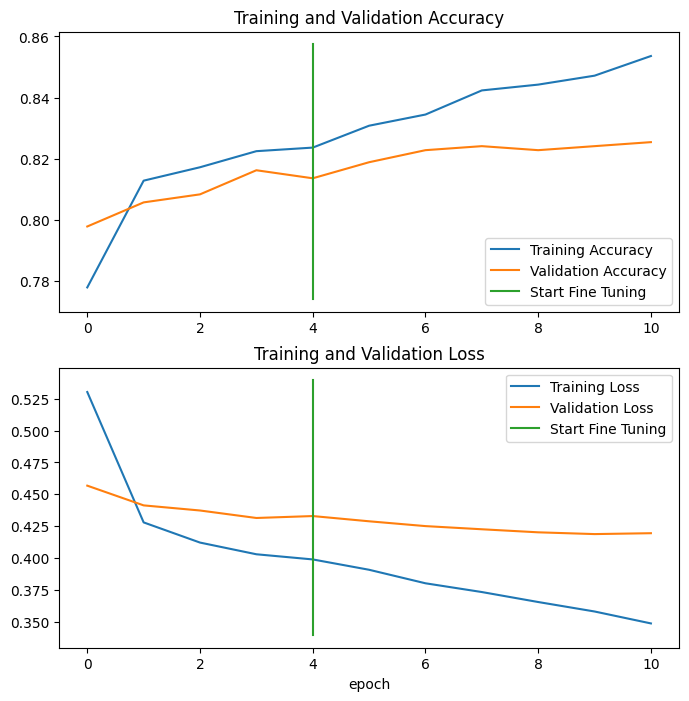

In [55]:
from helper_functions import compare_historys

compare_historys(model_6_history, model_6_fine_tuned_history, initial_epochs)

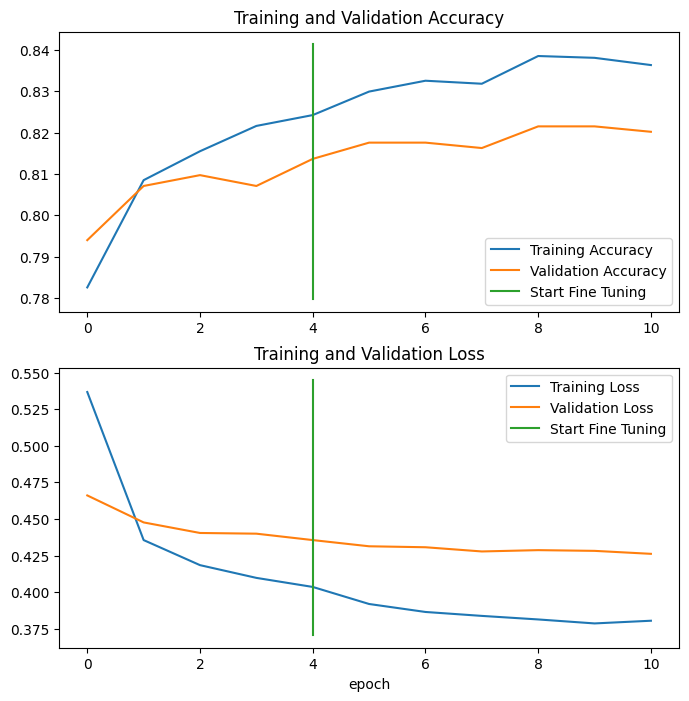

In [32]:
from helper_functions import compare_historys

compare_historys(model_6_history, model_6_fine_tuned_history, initial_epochs)

In [33]:
# Evaluate and pred
model_6_fine_tuning_preds = evaluate_and_pred(model_6, val_sentences, val_labels)
model_6_fine_tuning_preds[:10]

24/24 [==============================] - 0s 12ms/step - loss: 0.4262 - accuracy: 0.8202
Evaluation metrics: [0.4261607825756073, 0.8202099800109863]

24/24 [==============================] - 1s 10ms/step
Preds overview: [0. 1. 1. 0. 1. 1. 1. 1. 1. 0.]


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [34]:
# Calculate the results after fine tuning
model_6_fine_tuning_results = calculate_results(val_labels, model_6_fine_tuning_preds)
model_6_fine_tuning_results

{'accuracy': 0.8202099737532809,
 'precision': 0.8220363424159842,
 'recall': 0.8202099737532809,
 'f1-score': 0.8189174604110638}

In [35]:
# Compare the results
model_6_results

{'accuracy': 0.8136482939632546,
 'precision': 0.8149666868564506,
 'recall': 0.8136482939632546,
 'f1-score': 0.8124483019168057}

In [19]:
# Saving directory
MODEL_SAVE_DIR = "/content/drive/MyDrive/tensorflow/models/08_exercise_model_6_fine_tuned"

In [78]:
# Save the model
#model_6.save(MODEL_SAVE_DIR)

In [20]:
# Loading a model
loaded_model_6 = tf.keras.models.load_model(MODEL_SAVE_DIR)
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 7s 10ms/step - loss: 0.4177 - accuracy: 0.8255


[0.4176674485206604, 0.8254593014717102]

Looks that after a good chunk of experiments (slightly over 30) we've managed to get a model with `val_loss` under 0.42 which seemed a Holy Grail teritory at some point in time. However it was possible to do so and it's now saved, ready to be used again.

# Exercise 4
Retrain the best model you've got so far on the whole training set without the validation split. Then use this model to make predicions on the test dataset to use it on Kaggle Competition to see how you've performed.

In [36]:
# Remind ourselves of the data
train_data_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [38]:
## Recreating the most successful training loop
tf.random.set_seed(42)

# TF Hub model - USE
import tensorflow_hub as hub
USE_URL = "https://tfhub.dev/google/universal-sentence-encoder/4"
embed = hub.load(USE_URL)

# Load USE into KerasLayer
sentence_encoder_layer = hub.KerasLayer(handle=USE_URL,
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False, # USE layers frozen for feature extraction
                                        name='USE_fine_tuned')

# Create a base model_6 to fit on the data
model_final = tf.keras.Sequential([
    #layers.Input(shape=(1,), dtype=tf.string),
    sentence_encoder_layer,
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid', name='output_layer'),
], name='model_USE_final')

# Compile
model_final.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])

# Base fit
initial_epochs = 5

history_model_final = model_final.fit(train_data_shuffled['text'],
                                      train_data_shuffled['target'],
                                      epochs=initial_epochs,
                                      callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                             'model_final_USE')],
                                      )

# Unfreezing the USE layers for fine-tuning
for layer in model_final.layers:
  layer.trainable = True
  
# Recompiling the model for fine-tuning
model_final.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1.5e-5),
                    metrics=['accuracy'])

# Fine-tuning
fine_tuning_epochs = 5
total_epochs = initial_epochs + fine_tuning_epochs

history_model_final_fine_tuning = model_final.fit(train_data_shuffled['text'],
                                                  train_data_shuffled['target'],
                                                  epochs=total_epochs,
                                                  initial_epoch=history_model_final.epoch[-1],
                                                  callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                                         'model_final_USE_fine_tuned')]
                                                  )

Saving TensorBoard log files to: exercise_model_logs/model_final_USE/20230330-165744
Epoch 1/5
238/238 [==============================] - 6s 12ms/step - loss: 0.5340 - accuracy: 0.7745
Epoch 2/5
238/238 [==============================] - 4s 17ms/step - loss: 0.4337 - accuracy: 0.8091
Epoch 3/5
238/238 [==============================] - 3s 13ms/step - loss: 0.4158 - accuracy: 0.8157
Epoch 4/5
238/238 [==============================] - 3s 11ms/step - loss: 0.4063 - accuracy: 0.8229
Epoch 5/5
238/238 [==============================] - 3s 12ms/step - loss: 0.3985 - accuracy: 0.8249
Saving TensorBoard log files to: exercise_model_logs/model_final_USE_fine_tuned/20230330-165807
Epoch 5/10
238/238 [==============================] - 139s 464ms/step - loss: 0.3875 - accuracy: 0.8320
Epoch 6/10
238/238 [==============================] - 27s 112ms/step - loss: 0.3792 - accuracy: 0.8361
Epoch 7/10
238/238 [==============================] - 24s 101ms/step - loss: 0.3702 - accuracy: 0.8412
Epoch 8/1

In [41]:
# Make predictions on test Kaggle dataset
test_df = pd.read_csv('test.csv')
test_df.head()

test_pred_probs = model_final.predict(test_df['text'].to_list())
test_preds = tf.squeeze(tf.round(test_pred_probs))
test_preds[:10]

102/102 [==============================] - 2s 10ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 0., 0., 0., 0.], dtype=float32)>

In [46]:
submission = pd.DataFrame()
submission['id'] = test_df['id']
submission['target'] = tf.cast(test_preds, dtype=tf.int64)
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [47]:
submission.to_csv('submission_30032023.csv', index=False)

Kaggle results is 0.81642 which at the time of submission is rank 225 out of 1151 competitors.